## Feature selection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
pics = './pics'
tables = './tables'

In [3]:
new_df = pd.read_csv(f'{tables}/all_desc.csv')

In [4]:
new_df.isnull().values.any()

False

In [5]:
X = new_df.iloc[:,:-1]
y = new_df.label
# y

### Filtering invariant (1.13.1.) and highly correlated features

In [6]:
from sklearn.feature_selection import VarianceThreshold

def filter_data(X):
    correlation_threshold = 0.9
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]

    column_names = X.columns
    X = X.drop(to_drop, axis=1)
    
    variance_threshold = 0.9
    sel = VarianceThreshold(threshold=(variance_threshold * (1 - variance_threshold)))
    X = sel.fit_transform(X)
    kept_features = sel.get_support(indices=True)
    X = pd.DataFrame(X, columns=column_names[kept_features])

    return X

X = filter_data(X)

In [10]:
from numpy import mean
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance

from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

import warnings

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
y_test.value_counts()

label
0    3170
1     310
Name: count, dtype: int64

### Feature selection using Random Forest Classifier

In [11]:
Rtree_clf = RandomForestClassifier()
Rtree_clf = Rtree_clf.fit(X_train,y_train)
model = SelectFromModel(Rtree_clf, prefit=True)
RF_tree_featuresTrain = X_train.loc[:, model.get_support()]
RF_tree_featuresTest = X_test.loc[:, model.get_support()]
warnings.filterwarnings('ignore')

importances = Rtree_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in Rtree_clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
indices.shape
indices = indices[:200]

In [12]:
print(len(importances[indices]))

117


In [13]:
indices

array([ 47,  75,  87,  37,  17,  32,   8,   7,  29,  76,   6,  22,  85,
        92,  62,   2,  86,   0,  15,   4,  61,   1,  39,  30,  63,   5,
        57,  52,  42,  48,  64,  49,  28,  77,   9, 101,  11,  38,  18,
        59,   3,  10,  45,  93,  73,  40,  16,  50,  24,  12,  72,  36,
        13,  99,  21,  26,  66,  90,  43,  14,  65,  69,  34, 112,  23,
       113,  70,  54,  83,  88,  84,  25,  19,  58,  51,  78,  44,  55,
        35,  27,  41,  67,  60,  53,  56,  79,  20,  68,  74,  98,  94,
       111, 100,  33,  82, 103, 106, 109,  81, 104,  89,  71,  80,  96,
       116, 102,  46,  97, 107, 108,  31,  95,  91, 114, 115, 110, 105])

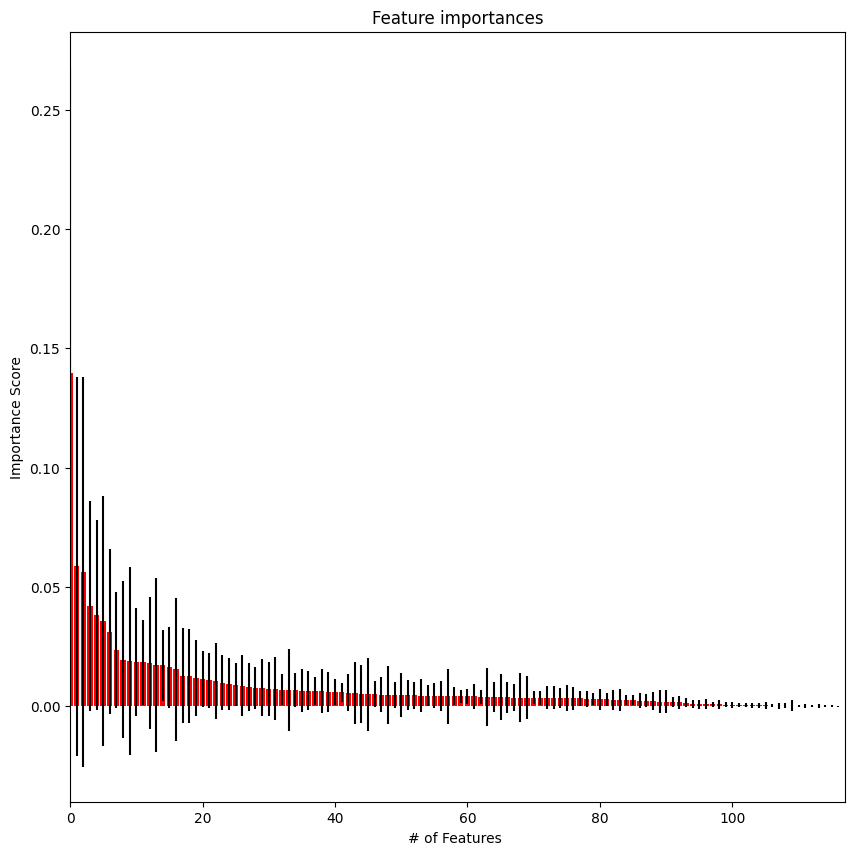

In [14]:
plt.figure(1, figsize=(10, 10))
plt.title("Feature importances")
plt.xlabel("# of Features ")
plt.ylabel("Importance Score")
plt.bar(range(len(importances[indices])), importances[indices], color="r", yerr=std[indices], align="center")
plt.xlim([0, len(importances[indices])])
# plt.show()
plt.savefig(f'{pics}/rf_feat_import.png')

### 1.13.3. Recursive Feature Elmination

In [15]:
from sklearn.feature_selection import RFECV, RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [16]:
clf = RandomForestClassifier(n_estimators=50, max_depth=10)
min_features_to_select = 20
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

size = 6050
rfecv.fit(X[:size], y[:size])
print('Optimal number of features :', rfecv.n_features_)

Optimal number of features : 83


In [17]:
# # Plot showing the Cross Validation score
# # Works only for old versions (sklearn = 1.2.2)
# fig, ax = plt.subplots(figsize=(10, 8))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(min_features_to_select + 1, min_features_to_select + len(rfecv.cv_results_) + 1), rfecv.cv_results_)
# plt.show()
# # plt.savefig(f'{pics}/rfecv_feat.png')

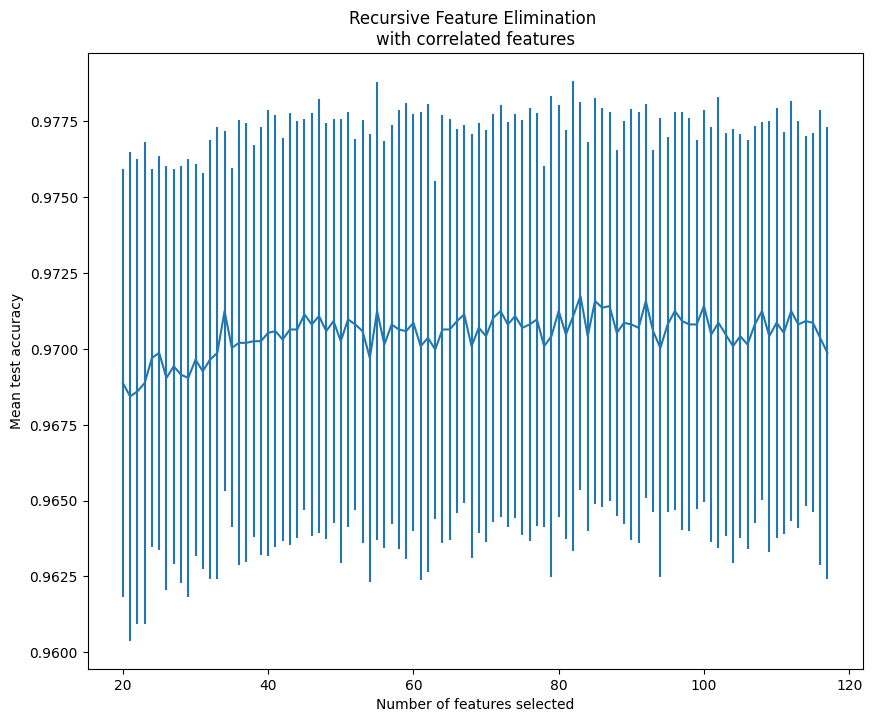

<Figure size 640x480 with 0 Axes>

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()
plt.savefig(f'{pics}/rfe_with_corr_feat.png')

### Applying RFE with optimal number of features found in RFECV

In [11]:
clf = RandomForestClassifier(n_estimators=50, max_depth=10)
rfe = RFE(estimator=clf, n_features_to_select=rfecv.n_features_, step=1)
rfe = rfe.fit(X_train, y_train)

NameError: name 'RFE' is not defined

In [22]:
rfe_train = pd.DataFrame(X_train).loc[:, rfe.get_support()]
rfe_test = pd.DataFrame(X_test).loc[:, rfe.get_support()]

print("Train Accuracy:",cross_val_score(clf,rfe_train,y_train, cv=5).mean())

clf = clf.fit(rfe_train, y_train)
y_pred = clf.predict(rfe_test)
print("Test Accuracy:", accuracy_score(y_pred, y_test))

print(classification_report(y_test, y_pred))

Train Accuracy: 0.991089700462323
Test Accuracy: 0.9879310344827587
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3170
           1       0.97      0.89      0.93       310

    accuracy                           0.99      3480
   macro avg       0.98      0.95      0.96      3480
weighted avg       0.99      0.99      0.99      3480



In [23]:
rfe.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True, False,  True,  True,  True,  True,  True, False, False,
       False, False,  True,  True,  True,  True,  True, False, False,
        True, False,  True,  True, False, False, False, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False,  True,  True,  True, False, False, False])

### Permutation importance

In [12]:
svc = svm.SVC(C=1, gamma=0.0001, random_state=0)
svc.fit(X_train, y_train)
perm_importance = permutation_importance(svc, X_test, y_test, n_jobs=-1)
features = np.array(X.columns)
sorted_idx = perm_importance.importances_mean.argsort()

#### Plot top 10 important features

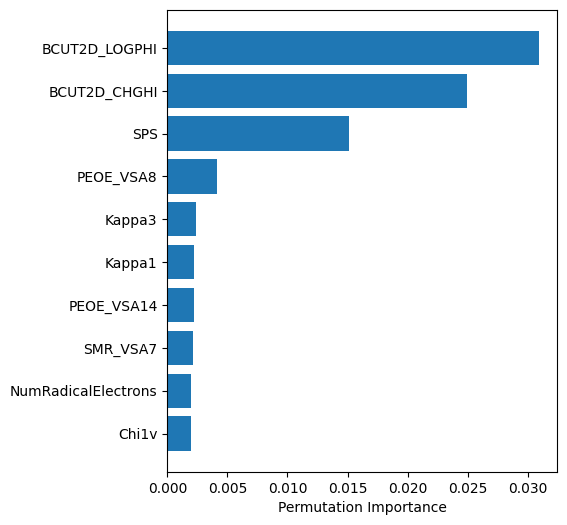

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.barh(features[sorted_idx][-10:], perm_importance.importances_mean[sorted_idx][-10:])
plt.xlabel("Permutation Importance")
plt.gcf().subplots_adjust(left=0.25)
plt.savefig(f'{pics}/top10_feat_perm.png')

#### Plot top 10 less important features

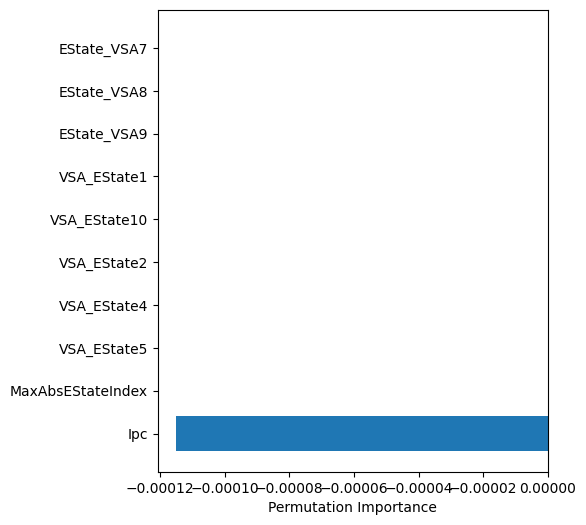

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.barh(features[sorted_idx][:10], perm_importance.importances_mean[sorted_idx][:10])
plt.xlabel("Permutation Importance")
plt.gcf().subplots_adjust(left=0.25)
plt.savefig(f'{pics}/top-10_feat_perm.png')

In [15]:
X

,MaxAbsEStateIndex,MinAbsEStateIndex,qed,SPS,NumRadicalElectrons,MaxPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,...,fr_alkyl_carbamate,fr_alkyl_halide,fr_aniline,fr_azide,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_hdrzine,fr_hdrzone
0,10.337455,-1.272753,23.375000,505.329,79.918731,10.123678,-2.326422,9.103951,-0.051090,3.459112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.335047,-1.271941,23.375000,505.329,79.918731,10.124302,-2.326422,9.103026,-0.051090,3.450909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.333078,-1.271281,23.375000,505.329,79.918731,10.124439,-2.326422,9.103025,-0.051090,3.448581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.355554,-1.235039,25.218750,440.504,16.562573,9.897992,-2.326488,5.825210,-0.051059,3.346646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.090409,0.226017,12.285714,362.614,79.918731,10.103988,-2.005563,9.101988,0.552888,3.020157,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34787,12.933117,-4.100987,14.468750,461.496,32.233273,10.184514,-2.413862,7.924364,-0.135518,3.193984,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
34788,5.666491,0.191419,19.187500,455.592,32.092047,10.229779,-2.513251,7.798553,0.113793,3.311255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34789,13.336315,-3.927724,12.322581,451.432,32.233166,10.212402,-2.348322,7.920932,-0.387066,2.725871,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
34790,13.414551,-4.286701,25.687500,468.395,31.204928,9.953594,-2.599988,7.489276,-0.306706,2.803642,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Finding the number of dimensions to transform using PCA

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 5)
pca_traindata = pca.fit(X_train)

In [17]:
pcatrain = pca_traindata.transform(X_train)
pcatest = pca_traindata.transform(X_test)
cum_ratio = (np.cumsum(pca_traindata.explained_variance_ratio_))

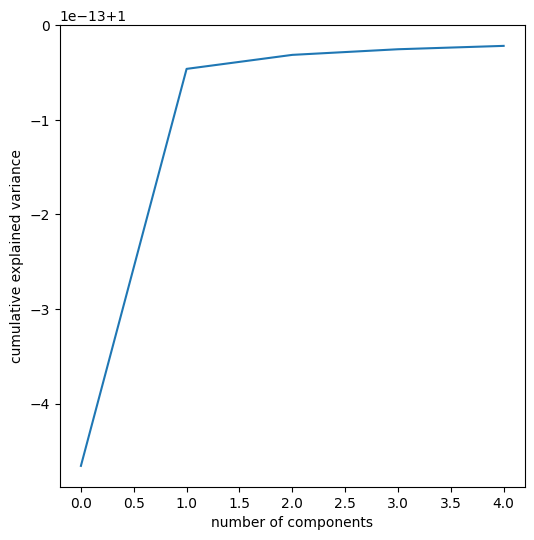

In [18]:

fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(cum_ratio)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()
# plt.savefig(f'{pics}/pca.png')

### Applying PCA with optimal number of features

In [19]:
pca = PCA(n_components = 100)
pca_traindata = pca.fit(X_train)

pcatrain = pca_traindata.transform(X_train)
pcatest = pca_traindata.transform(X_test)
(np.cumsum(pca_traindata.explained_variance_ratio_))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [20]:
import scikitplot as skplt
skplt.decomposition.plot_pca_2d_projection(pca, X_train, y_train)
# plt.show()
plt.savefig(f'{pics}/pc1pc2_relat.png')

ModuleNotFoundError: No module named 'scikitplot'

### Hierarchical clustering on the Spearman rank-order correlations

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

#### https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

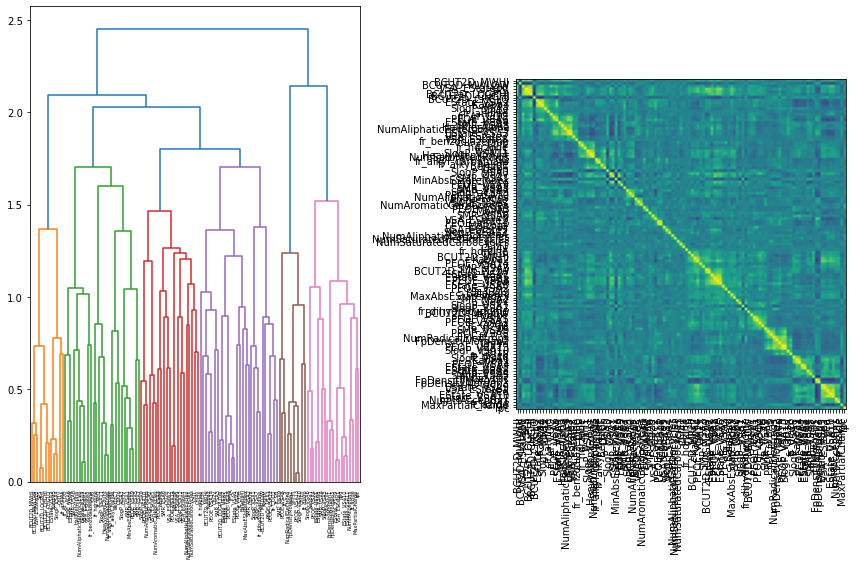

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

plt.savefig(f'{pics}/corr_hierarchy_spearmanr.png')

In [ ]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)

Baseline accuracy on test data with features removed: 0.99


NameError: name 'plot_permutation_importance' is not defined

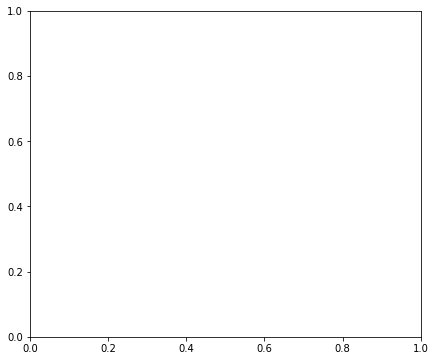

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
# plt.show()
plt.savefig(f'{pics}/perm_imp.png')